# Spectral Fit with systematics

Given a set of 1-dimensional PDFs, we would like to fit the number of events
of each type in the dataset, knowing their distributions _a priori_.

In [1]:
include("../src/WatchFish.jl")
using .WatchFish
using DataFrames
using PyPlot

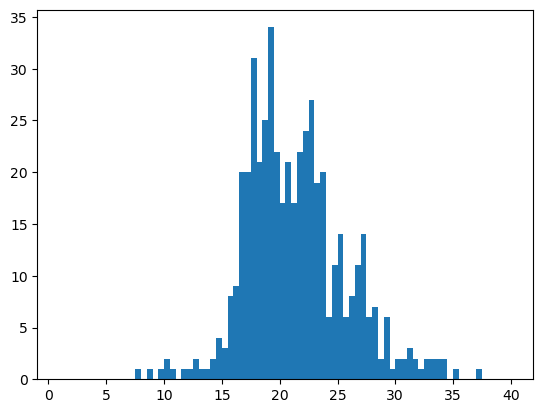

In [2]:
# Create a fake data set (stored in a dataframe)
function generate_dataset()
    norm = [150, 300, 40]
    mvs = [20.0, 23.0, 18.0] # mean values
    svs = [2.0, 5.0, 1.0]    # sigma values

    df1 = DataFrame(energy=( randn(norm[1]).*svs[1] .+ mvs[1] ) )
    append!(df1, DataFrame(energy=( randn(norm[2]).*svs[2] .+ mvs[2] ) ))
    append!(df1, DataFrame(energy=( randn(norm[3]).*svs[3] .+ mvs[3] ) ))

    # Stitch the dataset into the module
    add_dataset(:tri, df1 )
    WatchFish.tri
end

# Visualize the total dataset
data = generate_dataset()
plt.hist(data.energy, bins=collect(1:0.5:40))
plt.show()

In [3]:
# Put together a custom model to fit to the generated dataset
model = CustomModel()

@addfunction shape(μ, σ) = @. exp(-(tri.energy-μ)^2/2/σ^2)/sqrt(2π*σ^2)

## Free parameters
s  = Parameter("signal"; init=100.0)
b1 = Parameter("bkg1"; init=100.0)
b2 = Parameter("bkg2"; init=100.0)
## Data counts
observation_count = Parameter("obs"; init=Float64( size(data,1) ), constant=true )
## Known Means
sm  = Constant("Signal Mean", 20.0)
bm1 = Constant("Bkg1 Mean", 23.0)
bm2 = Constant("Bkg2 Mean", 18.0)
## Known Sigma
ss  = Constant("Signal Sig", 2.0)
bs1 = Constant("Bkg1 Sig", 5.0)
bs2 = Constant("Bkg2 Sig", 1.0)

## Build the PDF functions
@addfunction spectralpdf(b1, b2, b3, m1, m2, m3, s1, s2, s3) = begin
    -sum(log.( b1*shape(m1, s1) .+ b2*shape(m2, s2) .+ b3*shape(m3, s3) ))
end
@addfunction logextend(n, x...) = begin
    λ = sum([x...])
    λ + n*log(n) - n
end
## Construct NLL
ob1 = NLogPDF("spectralpdf", s, b1, b2, sm, bm1, bm2, ss, bs1, bs2)
ob2 = NLogPDF("logextend", observation_count, s, b1, b2)

## Include the above in our model
add_parameters!(model, [s, b1, b2, observation_count, sm, bm1, bm2, ss, bs1, bs2])
add_nlogpdfs!(model, [ob1, ob2])
@show model.lower_bounds
results = minimize!(model)

compute_profiled_uncertainties!(results; σ=1)
pretty_results(results)

model.lower_bounds = Float64[]


,Name,Fit,Interval_Low,Interval_High
,String,Float64,Float64,Float64
1,signal,130.699,105.699,156.699
2,bkg1,297.016,274.016,322.016
3,bkg2,62.2991,47.2991,77.2991


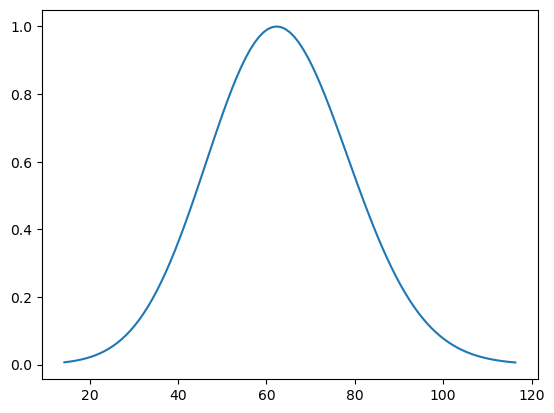

In [4]:
a = getparam(results.model, "bkg2")
x = a.likelihood_x
y = a.likelihood_y
plt.plot(x, y)
plt.show()

In [5]:
## Given that the model is ready, we could run it over many datasets
trials = 3

fit_set = []
for i = 1:trials
    generate_dataset()
    iter_results = minimize!(model)
    push!(fit_set, iter_results.min_parameters)
end

@show fit_set

fit_set = Any[[138.4650631144848, 315.7663650428945, 35.83519569486964], [128.9520146632147, 310.79544927868926, 50.2773499092211], [126.61262919065747, 296.0679078220087, 67.34354817536229]]


3-element Array{Any,1}:
 [138.4650631144848, 315.7663650428945, 35.83519569486964] 
 [128.9520146632147, 310.79544927868926, 50.2773499092211] 
 [126.61262919065747, 296.0679078220087, 67.34354817536229]

In [ ]:
correlation_plots2(results)